In [36]:

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

In [37]:
# read training and test data from csv files
TRAINING_PATH = "./train.csv"
TESTING_PATH = "./test.csv"

In [38]:

spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()
sc = spark.sparkContext

In [39]:
all_training_rdd = spark.read.csv(TRAINING_PATH, header=True, inferSchema=True)
testing_rdd = spark.read.csv(TESTING_PATH, header=True, inferSchema=True)

# split training into training and validation
(training_rdd, validation_rdd) = all_training_rdd.randomSplit([0.8, 0.2])

In [40]:
# training_rdd.show(10)
# testing_rdd.show(10)

# print dataset length
print("Training data length: ", training_rdd.count())
print("Testing data length: ", testing_rdd.count())

# print the count of label values in training data
training_rdd.groupBy("label").count().show()
testing_rdd.groupBy("label").count().show()

Training data length:  141996
Testing data length:  58329
+-----+-----+
|label|count|
+-----+-----+
|    1|81325|
|    0|60671|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    1|33370|
|    0|24959|
+-----+-----+



In [41]:
33370 / (33370+24959)

0.5720996416876682

In [42]:
# print column data types
training_rdd.printSchema()

root
 |-- URLLength: integer (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- CharContinuationRate: double (nullable = true)
 |-- TLDLegitimateProb: double (nullable = true)
 |-- URLCharProb: double (nullable = true)
 |-- NoOfSubDomain: integer (nullable = true)
 |-- LetterRatioInURL: double (nullable = true)
 |-- DegitRatioInURL: double (nullable = true)
 |-- SpacialCharRatioInURL: double (nullable = true)
 |-- LineOfCode: integer (nullable = true)
 |-- LargestLineLength: integer (nullable = true)
 |-- URLTitleMatchScore: double (nullable = true)
 |-- NoOfURLRedirect: integer (nullable = true)
 |-- NoOfSelfRedirect: integer (nullable = true)
 |-- NoOfPopup: integer (nullable = true)
 |-- NoOfiFrame: integer (nullable = true)
 |-- NoOfImage: integer (nullable = true)
 |-- NoOfCSS: integer (nullable = true)
 |-- NoOfJS: integer (nullable = true)
 |-- NoOfSelfRef: integer (nullable = true)
 |-- NoOfEmptyRef: integer (nullable = true)
 |-- NoOfExternalRef: integer 

In [43]:
effective_cols = [
    "URLLength",
    "URLSimilarityIndex",
    "CharContinuationRate",
    "URLCharProb",
    "NoOfSubDomain",
    "DegitRatioInURL",
    "SpacialCharRatioInURL",
    "URLTitleMatchScore",
    "NoOfImage",
    "NoOfJS",
    "IsHTTPS",
    "HasTitle",
    "IsResponsive",
    "HasDescription",
    "HasExternalFormSubmit",
    "HasSocialNet",
    "HasSubmitButton",
    "HasHiddenFields",
    "HasPasswordField",
    "Bank",
    "Pay",
    "Crypto",
    "HasCopyrightInfo"
]

print("Effective columns: ", len(effective_cols))

Effective columns:  23


with cross validation


In [44]:
def run_cross_validation_random_forest(
    training_df, testing_df
):
    # Create the Random Forest classifier

    rf = RandomForestClassifier(labelCol="label", featuresCol="features")

    # Create a parameter grid for tuning the model's hyperparameters

    param_grid = (ParamGridBuilder()
                  .addGrid(rf.numTrees, [10, 50, 100])
                  .addGrid(rf.maxDepth, [5, 10, 15])
                  .addGrid(rf.maxBins, [32, 64])
                  .build())

    # Create a cross-validator

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")

    cross_validator = CrossValidator(estimator=rf,
                                     estimatorParamMaps=param_grid,
                                     evaluator=evaluator,
                                     numFolds=5)  # Use 5-fold cross-validation

    # Fit the cross-validator to the training data

    cv_model = cross_validator.fit(training_df)

    # Use the best model to make predictions on the test set

    predictions = cv_model.transform(testing_df)

    # Evaluate the best model using accuracy

    accuracy = evaluator.evaluate(predictions)

    print(f"Test Accuracy = {accuracy:.4f}")

    # Evaluate using additional metrics

    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

    precision = precision_evaluator.evaluate(predictions)

    print(f"Test Precision = {precision:.4f}")

    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedRecall")

    recall = recall_evaluator.evaluate(predictions)

    print(f"Test Recall = {recall:.4f}")

    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1")

    f1 = f1_evaluator.evaluate(predictions)

    print(f"Test F1 Score = {f1:.4f}")

    # Plot confusion matrix

    predictions.groupBy("label", "prediction").count().show()

In [45]:
# run cross validation

# Convert the data to dense vectors
assembler = VectorAssembler(inputCols=effective_cols, outputCol="features")

training_df = assembler.transform(training_rdd)
testing_df = assembler.transform(testing_rdd)

run_cross_validation_random_forest(training_df, testing_df)

Test Accuracy = 0.9999
Test Precision = 0.9999
Test Recall = 0.9999
Test F1 Score = 0.9999
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|24955|
|    1|       1.0|33370|
|    0|       1.0|    4|
+-----+----------+-----+



In [46]:
def eval_model(predictions, eval_label="Test"):
    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"{eval_label} Accuracy = {accuracy:.20f}")

    # show presicion, recall and f1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    precision = evaluator.evaluate(predictions)
    print(f"{eval_label} Precision = {precision:.20f}")

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    recall = evaluator.evaluate(predictions)
    print(f"{eval_label} Recall = {recall:.20f}")

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator.evaluate(predictions)
    print(f"{eval_label} F1 Score = {f1:.20f}")

    return accuracy, precision, recall, f1

In [47]:
def run_random_forest(
    training_df, testing_df, validation_df, feature_columns
):

    # Create and train the Random Forest classifier
    rf = RandomForestClassifier(
        labelCol="label", featuresCol="features", seed=285)
    rf_model = rf.fit(training_df)

    # Make predictions on the test set
    predictions = rf_model.transform(testing_df)
    # Evaluate the model
    accuracy, precision, recall, f1 = eval_model(predictions, "Test")

    predictions_validation = rf_model.transform(validation_df)
    # Evaluate the model
    val_accuracy, val_precision, val_recall, val_f1 = eval_model(
        predictions_validation, "Validation")

    # Retrieve the feature importances from the model as a list
    importances = rf_model.featureImportances.toArray()
    # print(importances)

    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    sorted_importances = np.array(importances)[indices]
    sorted_feature_names = np.array(feature_columns)[indices]

    print(sorted_importances)
    print(sorted_feature_names)

    # Create a horizontal bar plot showing the feature importances
    plt.figure(figsize=(5, 5))
    plt.title("Feature Importances")
    plt.barh(range(len(importances)), np.array(
        importances)[indices], align='center')
    plt.yticks(range(len(importances)), np.array(feature_columns)[indices])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
    plt.show()

    # show accumulated importance on
    importances = np.array(importances)
    indices = np.argsort(importances)[::-1]
    importances = importances[indices]
    cum_importances = np.cumsum(importances)
    plt.figure(figsize=(5, 5))
    plt.title("Cumulative Feature Importances")
    plt.plot(range(len(importances)), cum_importances, 'b-')
    plt.xlabel("Number of Features")
    plt.ylabel("Cumulative Importance")
    plt.grid(True)
    plt.show()

    # Plot confusion matrix using sklearn
    y_true = predictions.select("label").toPandas()
    y_pred = predictions.select("prediction").toPandas()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=True, yticklabels=True)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    # return presicion, recall, f1 and cum_importances
    return precision, recall, f1, cum_importances, sorted_feature_names

In [48]:
def select_important_features(cum_importances, sorted_feature_names, threshold=0.9):
    # Pick the features that contribute up to {threshold}% of importance

    num_important_features = np.argmax(cum_importances >= threshold) + 1

    # Get the selected feature names
    selected_features = sorted_feature_names[:num_important_features]

    print(
        f"Number of features contributing up to {threshold * 100}% importance: {num_important_features}")
    print("Selected features:", selected_features)

    return selected_features

['URLLength', 'URLSimilarityIndex', 'CharContinuationRate', 'URLCharProb', 'NoOfSubDomain', 'DegitRatioInURL', 'SpacialCharRatioInURL', 'URLTitleMatchScore', 'NoOfImage', 'NoOfJS', 'IsHTTPS', 'HasTitle', 'IsResponsive', 'HasDescription', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo']


Test Accuracy = 0.99991427934646570641
Test Precision = 0.99991427951385736250
Test Recall = 0.99991427934646570641
Test F1 Score = 0.99991427913002262073
Validation Accuracy = 0.99991439577685836682
Validation Precision = 0.99991439819350480533
Validation Recall = 0.99991439577685836682
Validation F1 Score = 0.99991439615223709492
[2.93056322e-01 2.11877227e-01 1.42101118e-01 1.27929111e-01
 8.78822674e-02 4.53338067e-02 2.98876039e-02 1.59570818e-02
 1.30375897e-02 1.27048327e-02 6.24695916e-03 3.53103324e-03
 2.71951829e-03 2.49890228e-03 2.31974486e-03 1.26173093e-03
 1.22696286e-03 2.89187530e-04 1.36223047e-04 2.77859461e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
['URLSimilarityIndex' 'HasSocialNet' 'NoOfJS' 'NoOfImage' 'HasDescription'
 'IsHTTPS' 'DegitRatioInURL' 'IsResponsive' 'HasCopyrightInfo' 'URLLength'
 'SpacialCharRatioInURL' 'HasHiddenFields' 'HasTitle'
 'CharContinuationRate' 'NoOfSubDomain' 'URLCharProb' 'URLTitleMatchScore'
 'HasSubmitButton' 'Pay' 'HasPasswo

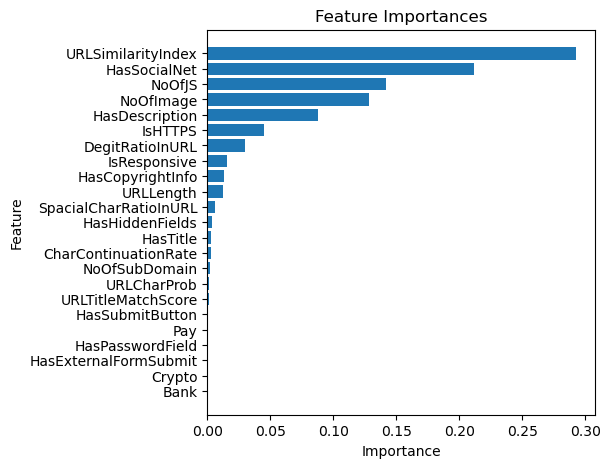

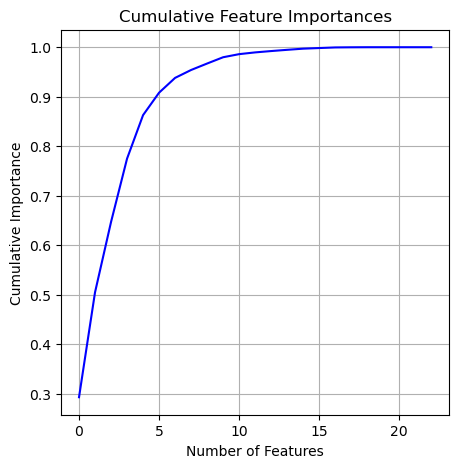

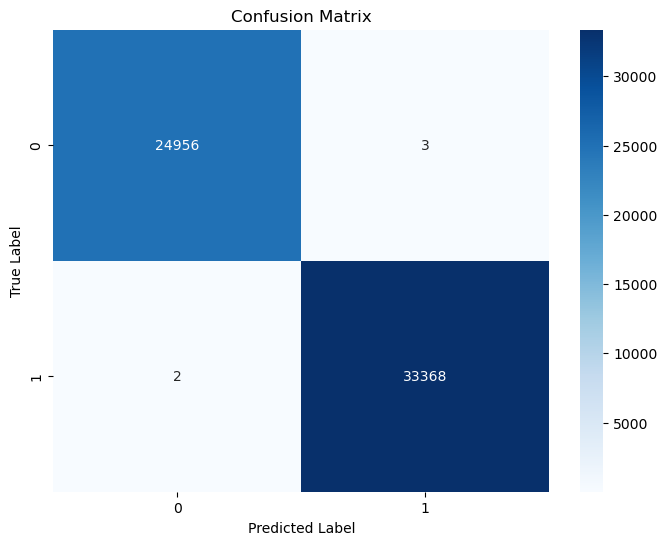

r1_cum_importances
[0.29305632 0.50493355 0.64703467 0.77496378 0.86284604 0.90817985
 0.93806746 0.95402454 0.96706213 0.97976696 0.98601392 0.98954495
 0.99226447 0.99476337 0.99708312 0.99834485 0.99957181 0.999861
 0.99999722 1.         1.         1.         1.        ]
Number of features contributing up to 90.0% importance: 6
Selected features: ['URLSimilarityIndex' 'HasSocialNet' 'NoOfJS' 'NoOfImage' 'HasDescription'
 'IsHTTPS']
s_features
['URLSimilarityIndex' 'HasSocialNet' 'NoOfJS' 'NoOfImage' 'HasDescription'
 'IsHTTPS']
Test Accuracy = 0.99984570282363838256
Test Precision = 0.99984574442687945695
Test Recall = 0.99984570282363827154
Test F1 Score = 0.99984569931378508567
Validation Accuracy = 0.99988586103581111875
Validation Precision = 0.99988588368355446612
Validation Recall = 0.99988586103581100772
Validation F1 Score = 0.99988585903180127179
[0.44424444 0.36574898 0.15973893 0.01364488 0.01221885 0.00440392]
['URLSimilarityIndex' 'NoOfImage' 'NoOfJS' 'IsHTTPS' 'HasSoci

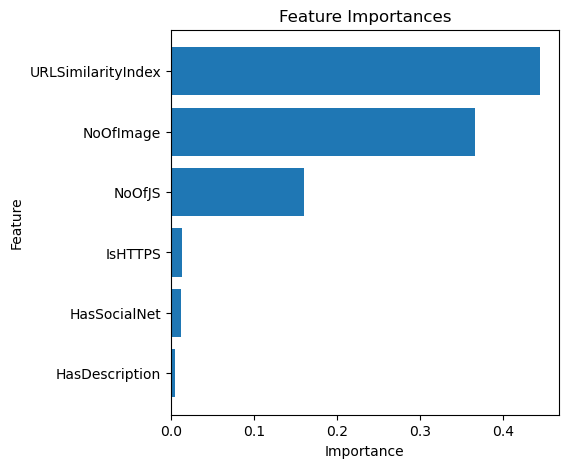

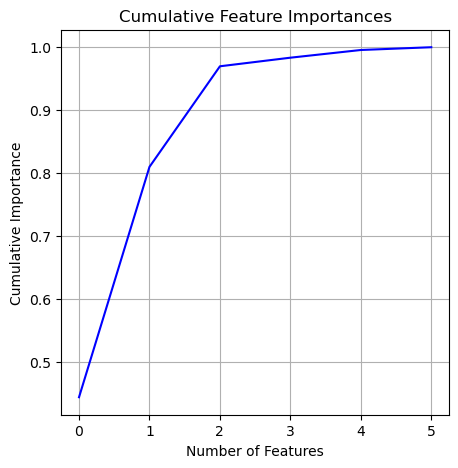

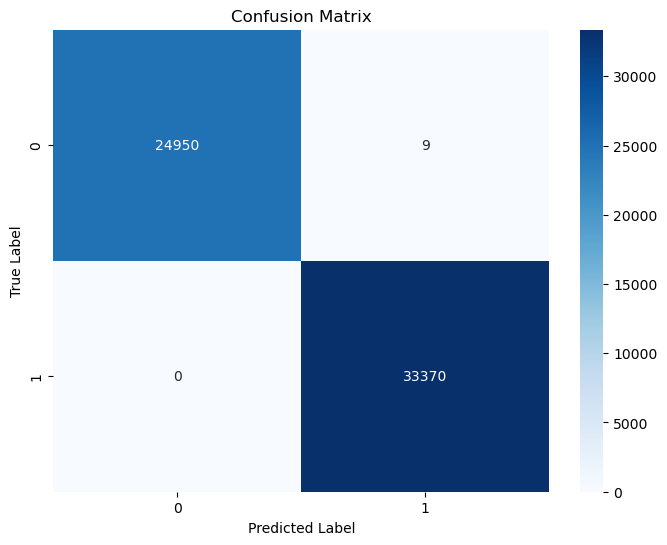

(0.9998457444268795,
 0.9998457028236383,
 0.9998456993137851,
 array([0.44424444, 0.80999342, 0.96973235, 0.98337723, 0.99559608,
        1.        ]),
 array(['URLSimilarityIndex', 'NoOfImage', 'NoOfJS', 'IsHTTPS',
        'HasSocialNet', 'HasDescription'], dtype='<U21'))

In [49]:

# Specify the feature columns, excluding the label column
feature_columns = [
    col for col in training_rdd.columns if col in effective_cols]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
print(feature_columns)
# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")
validation_df = assembler.transform(validation_rdd).select("features", "label")


_, _, _, r1_cum_importances, r1_sorted_feature_names = run_random_forest(
    train_df, test_df, validation_df, feature_columns)

print("r1_cum_importances")
print(r1_cum_importances)

s_features = select_important_features(
    r1_cum_importances, r1_sorted_feature_names, 0.9)
assembler = VectorAssembler(inputCols=s_features, outputCol="features")
print("s_features")
print(s_features)
# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")

# train_df.head()
test_df = assembler.transform(testing_rdd).select("features", "label")
validation_df = assembler.transform(validation_rdd).select("features", "label")

run_random_forest(train_df, test_df, validation_df, s_features)

Test Accuracy = 0.99583397623823488587
Test Precision = 0.99583423528193537599
Test Recall = 0.99583397623823477485
Test F1 Score = 0.99583350029538431070
Validation Accuracy = 0.99577685832501072749
Validation Precision = 0.99577673656942833347
Validation Recall = 0.99577685832501061647
Validation F1 Score = 0.99577678417664317045
[2.14885677e-01 1.95884093e-01 1.54067512e-01 1.28683121e-01
 6.45557806e-02 5.65017615e-02 5.24703048e-02 4.11572683e-02
 3.58735668e-02 2.02526118e-02 1.20921322e-02 8.46168379e-03
 7.07230096e-03 4.04729470e-03 1.67200269e-03 1.63915628e-03
 2.00493508e-04 1.77894311e-04 1.68732747e-04 1.36612142e-04
 0.00000000e+00 0.00000000e+00]
['HasSocialNet' 'NoOfImage' 'NoOfJS' 'HasCopyrightInfo' 'HasDescription'
 'HasSubmitButton' 'IsHTTPS' 'DegitRatioInURL' 'URLLength'
 'URLTitleMatchScore' 'SpacialCharRatioInURL' 'NoOfSubDomain'
 'CharContinuationRate' 'IsResponsive' 'URLCharProb' 'HasHiddenFields'
 'HasPasswordField' 'Pay' 'Bank' 'HasTitle' 'HasExternalFormSubm

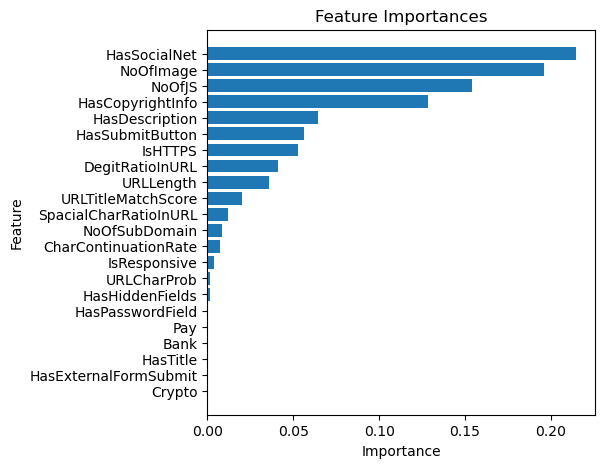

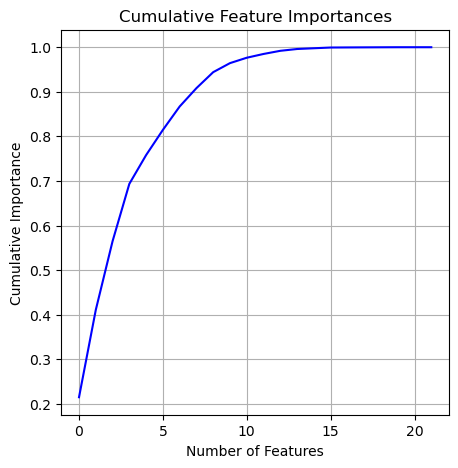

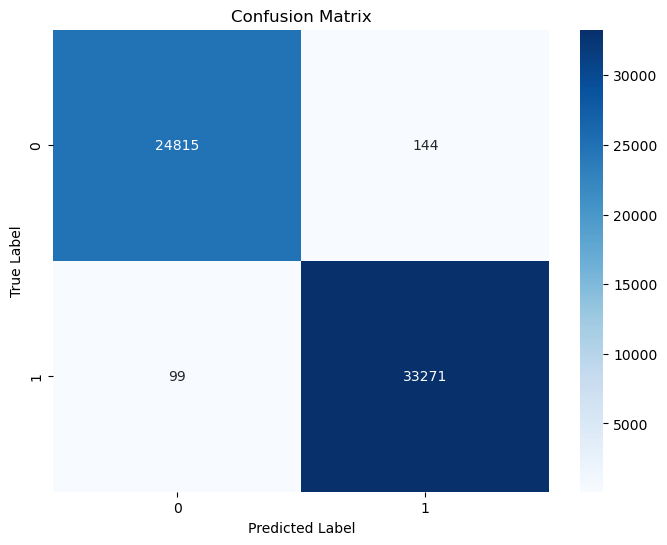

(0.9958342352819354,
 0.9958339762382348,
 0.9958335002953843,
 array([0.21488568, 0.41076977, 0.56483728, 0.6935204 , 0.75807618,
        0.81457794, 0.86704825, 0.90820552, 0.94407908, 0.9643317 ,
        0.97642383, 0.98488551, 0.99195781, 0.99600511, 0.99767711,
        0.99931627, 0.99951676, 0.99969466, 0.99986339, 1.        ,
        1.        , 1.        ]),
 array(['HasSocialNet', 'NoOfImage', 'NoOfJS', 'HasCopyrightInfo',
        'HasDescription', 'HasSubmitButton', 'IsHTTPS', 'DegitRatioInURL',
        'URLLength', 'URLTitleMatchScore', 'SpacialCharRatioInURL',
        'NoOfSubDomain', 'CharContinuationRate', 'IsResponsive',
        'URLCharProb', 'HasHiddenFields', 'HasPasswordField', 'Pay',
        'Bank', 'HasTitle', 'HasExternalFormSubmit', 'Crypto'],
       dtype='<U21'))

In [50]:

# Specify the feature columns, excluding the label column
feature_columns = [
    col for col in training_rdd.columns if col in effective_cols and col != "URLSimilarityIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")
validation_df = assembler.transform(validation_rdd).select("features", "label")

run_random_forest(train_df, test_df, validation_df, feature_columns)

Test Accuracy = 0.99646830907438843639
Test Precision = 0.99648997718049614480
Test Recall = 0.99646830907438843639
Test F1 Score = 0.99646642533797180619
Validation Accuracy = 0.99728919960051365390
Validation Precision = 0.99730191693572112221
Validation Recall = 0.99728919960051354288
Validation F1 Score = 0.99728804876363197351
[1.]
['URLSimilarityIndex']


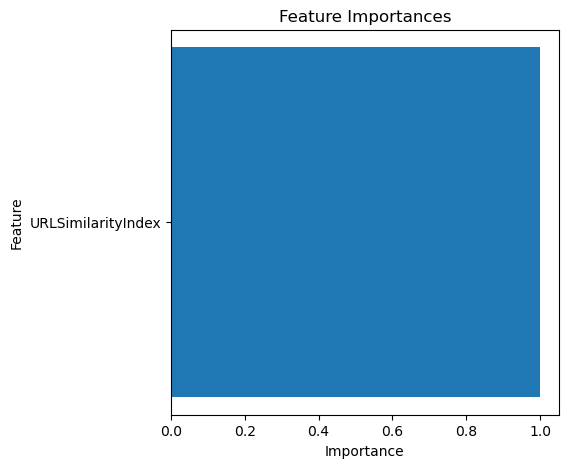

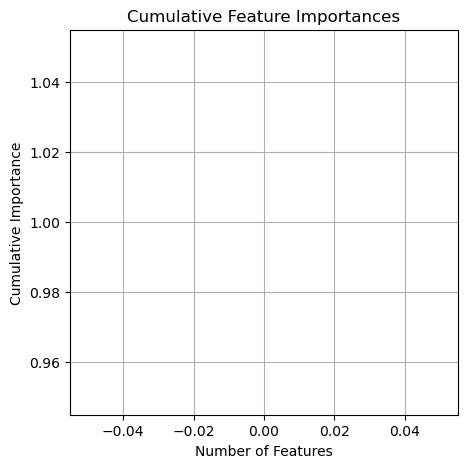

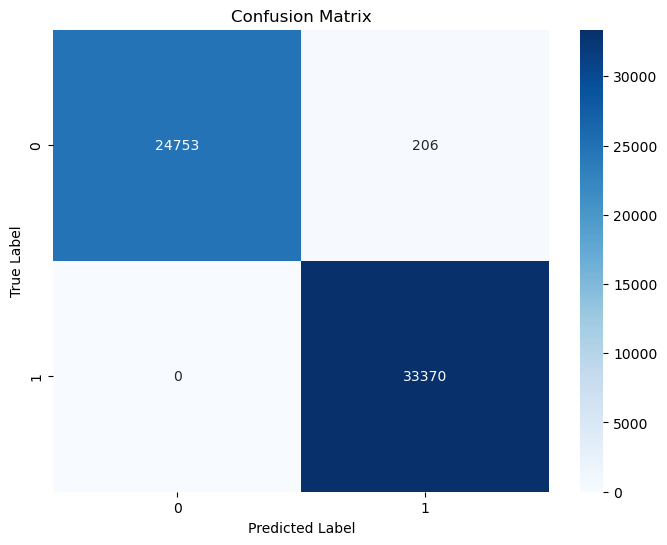

(0.9964899771804961,
 0.9964683090743884,
 0.9964664253379718,
 array([1.]),
 array(['URLSimilarityIndex'], dtype='<U18'))

In [51]:
# using similarity index only
feature_columns = ["URLSimilarityIndex",]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")
validation_df = assembler.transform(validation_rdd).select("features", "label")


run_random_forest(train_df, test_df, validation_df, feature_columns)

In [52]:
# s_features to array
# s_features = s_features[0]
# s_features

In [53]:
s_features = select_important_features(
    r1_cum_importances, r1_sorted_feature_names, 0.9)

Number of features contributing up to 90.0% importance: 6
Selected features: ['URLSimilarityIndex' 'HasSocialNet' 'NoOfJS' 'NoOfImage' 'HasDescription'
 'IsHTTPS']


In [54]:
# Example assuming training_rdd and testing_rdd are DataFrames
selected_columns = [f for f in s_features]
selected_columns.append("label")
selected_columns

['URLSimilarityIndex',
 'HasSocialNet',
 'NoOfJS',
 'NoOfImage',
 'HasDescription',
 'IsHTTPS',
 'label']

In [55]:
# write the data with the selected feature columns to csv
training_rdd.select(selected_columns).toPandas().to_csv(
    "train_selected.csv", index=False, header=True)
testing_rdd.select(selected_columns).toPandas().to_csv(
    "test_selected.csv", index=False, header=True)

In [56]:
# actual_dataset = pd.read_csv("./test.csv")

# # plot URLSimilarityIndex of rows with label 1
# plt.figure(figsize=(10, 5))
# plt.title("URLSimilarityIndex of Phishing URLs")
# plt.hist(actual_dataset[actual_dataset["label"] == 1]
#          ["URLSimilarityIndex"],  color='r', alpha=0.7)
# plt.xlabel("URLSimilarityIndex")
# plt.ylabel("Frequency")
# plt.show()


# # print the count of phishing urls with URLSimilarityIndex 100
# print("Phishing URLs with URLSimilarityIndex 100: ",
#       actual_dataset[(actual_dataset["label"] == 0) & (actual_dataset["URLSimilarityIndex"] == 100)].shape[0])